# Детекция объектов VOC2012 (Faster RCNN)

## Импорт библиотек

In [1]:
# Для загрузки и анализа данных
import os
import tarfile
import urllib.request
import glob
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from tqdm import tqdm
from sklearn import preprocessing
from time import time

# Для работы с изображениями
import torchvision
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.ops.boxes import nms
import torchvision.transforms.v2 as TV2
from PIL import Image

import cv2
import squarify
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from IPython.display import display

# Для построения модели
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Загрузка данных

Будем использовать набор данных PASCAL Visual Object Classes ([VOC](http://host.robots.ox.ac.uk/pascal/VOC/index.html)), в котором присутствует 20 классов изображений.

In [2]:
# Загрузка датасета
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar",
            "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

Экспортируем информацию из аннотаций с помощью функции `xml_to_csv`.

In [3]:
# Путь до папки с датасетом
DATASET_PATH = "/kaggle/working/VOCdevkit/VOC2012"
# Путь до папки с аннотациями
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "Annotations")
# Путь до папки с изображениями
IMAGES_PATH = os.path.join(DATASET_PATH, "JPEGImages")

# Функция для парсинга xml-файлов
def xml_to_csv(path=ANNOTATIONS_PATH):
    xml_list = []
    for xml_file in tqdm(glob.glob(path + '/2010*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for obj in root.findall('object'):
            bbx = obj.find('bndbox')
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            name = obj.find('name').text

            value = (root.find('filename').text,
                     width, height, name,
                     xmin, ymin, xmax, ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'name', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

Сохраним полученную информацию в VOC_2010.csv файл.

In [4]:
xml_df = xml_to_csv()
xml_df.to_csv('xml_df.csv', index=None)
print('Successfully converted xml to csv.')

100%|██████████| 3503/3503 [00:00<00:00, 10082.48it/s]


Successfully converted xml to csv.


In [5]:
xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax
0,2010_006453.jpg,500,375,person,50,169,122,329
1,2010_005127.jpg,500,333,person,149,28,369,323
2,2010_001694.jpg,500,358,cow,188,131,299,301
3,2010_000792.jpg,500,375,person,95,190,374,375
4,2010_000792.jpg,500,375,person,379,238,500,375


In [7]:
print(f'Общее количество объектов {xml_df.shape[0]}')
print(f'Количество изображений в датафрэйме {len(np.unique(xml_df["filename"]))}')

Общее количество объектов 7760
Количество изображений в датафрэйме 3503


## Обработка данных

Закодируем классы обьектов.

In [8]:
le = preprocessing.LabelEncoder()
xml_df['class'] = le.fit_transform(xml_df['name'])

xml_df.head()

,filename,width,height,name,xmin,ymin,xmax,ymax,class
0,2010_006453.jpg,500,375,person,50,169,122,329,14
1,2010_005127.jpg,500,333,person,149,28,369,323,14
2,2010_001694.jpg,500,358,cow,188,131,299,301,9
3,2010_000792.jpg,500,375,person,95,190,374,375,14
4,2010_000792.jpg,500,375,person,379,238,500,375,14


In [9]:
mapping = dict(zip(le.classes_, range(len(le.classes_))))
labels_dict = dict(zip(mapping.values(), mapping.keys()))
labels_dict

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

## Формируем датасет

Разделим выборку на train и val.

In [10]:
image_ids = xml_df['filename'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
valid_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Число изображений: {len(image_ids)}')
print(f'Объем train выборки: {len(train_ids)}')
print(f'Объем valid выборки: {len(valid_ids)}')

Число изображений: 3503
Объем train выборки: 2802
Объем valid выборки: 701


In [11]:
train_df = xml_df[xml_df['filename'].isin(train_ids)]
valid_df = xml_df[xml_df['filename'].isin(valid_ids)]

А что там с балансом классов?

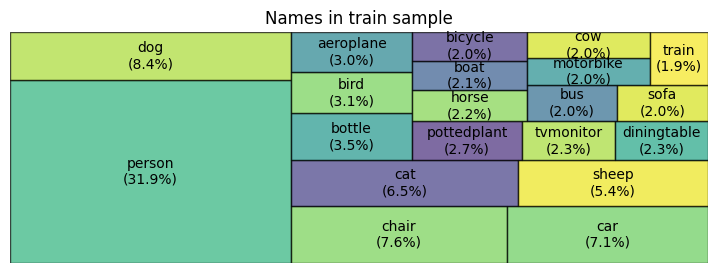

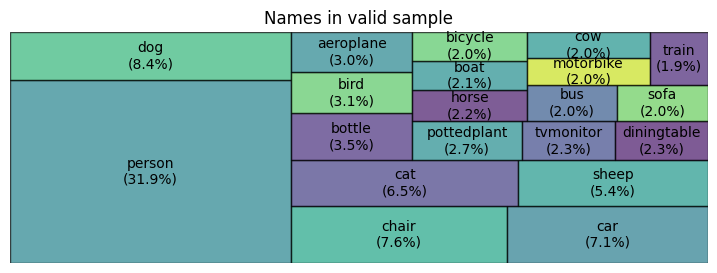

In [12]:
# Получаем распределение значений столбца 'name' с нормализацией
train_names_vls_cnts = train_df['name'].value_counts(normalize=True)
valid_names_vls_cnts = valid_df['name'].value_counts(normalize=True)

# Функция для получения иерархической диаграммы
def get_hierarchical_diagram(vls_cnts, sample='train'):
    plt.figure(figsize=(9, 3))
    squarify.plot(
        sizes=vls_cnts,
        label=[f'{label}\n({value:.1%})' for label, value in zip(
            vls_cnts.index, vls_cnts
            )],
        alpha=0.7, edgecolor='black')
    plt.axis('off')  
    plt.title(f'Names in {sample} sample')
    plt.show()
    
for vls_cnts, sample_name in [(train_names_vls_cnts, 'train'), (train_names_vls_cnts, 'valid')]:
    get_hierarchical_diagram(vls_cnts, sample=sample_name)

Выборки по составу идентичны, однако налицо сильный дисбаланс классов.

Идем дальше. Пропишем функцию для аугментации:

In [13]:
# Функция для аугментации данных
def get_transforms(phase):
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([
            A.Flip(p=0.5),
            ])
    list_transforms.extend([ToTensorV2(),])
    list_trms = A.Compose(
        list_transforms,
        bbox_params={'format': 'pascal_voc', 'label_fields':['labels']}
    )

    return list_trms

Напишем класс `VOC_2010()` для загрузки данных в модель.

In [14]:
class VOC_2010(Dataset):
    def __init__(self, df, image_dir, phase='train'):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.images = df['filename'].unique()
        self.transforms = get_transforms(phase)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image = self.images[idx]
        image_id = str(image.split('.')[0])

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)

        # Нормализация данных
        image_arr /= 255.0

        point = self.df[self.df['filename'] == image]
        boxes = point[['xmin', 'ymin', 'xmax', 'ymax']].values

        # Площадь внутри bbox
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # Запишем класс объекта в переменную label
        labels = torch.as_tensor(point['class'].values, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['boxes'] = torch.stack(
            tuple(map(torch.tensor, zip(*sample['bboxes'])))
        ).permute(1, 0)

        return image, target, image_id


In [15]:
train_data = VOC_2010(train_df, IMAGES_PATH, phase='train')
valid_data = VOC_2010(valid_df, IMAGES_PATH, phase='validation')

print(f'Размер обучающей выборки {len(train_data)}')
print(f'Размер валидационной выборки {len(valid_data)}')

Размер обучающей выборки 2802
Размер валидационной выборки 701


In [16]:
BATCH_SIZE = 4

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

## Визуализация данных

In [17]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    plt.figure(figsize=(10, 8))
    img = data.__getitem__(idx)
    image = image_convert(img[0])
    image = np.ascontiguousarray(image)
    bbox = img[1]['boxes']
    BOX_COLOR = (0, 255, 0)

    for j, box in enumerate(bbox):
        class_name = labels_dict[img[1]['labels'][j].item()]
        cv2.rectangle(
            image, (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            BOX_COLOR, thickness=1
            )
        ((text_width, text_height), _) = cv2.getTextSize(
            class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
            )
        cv2.rectangle(
            image, (int(box[0]), int(box[1]) - int(1.3 * text_height)),
            (int(box[0]) + text_width, int(box[1])), BOX_COLOR, -1
            )
        cv2.putText(
            image,
            text=class_name,
            org=(int(box[0]), int(box[1]) - int(0.3 * text_height)),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.35,
            color=(255, 255, 255),
            lineType=cv2.LINE_AA,
        )
    plt.imshow(image)
    plt.show()

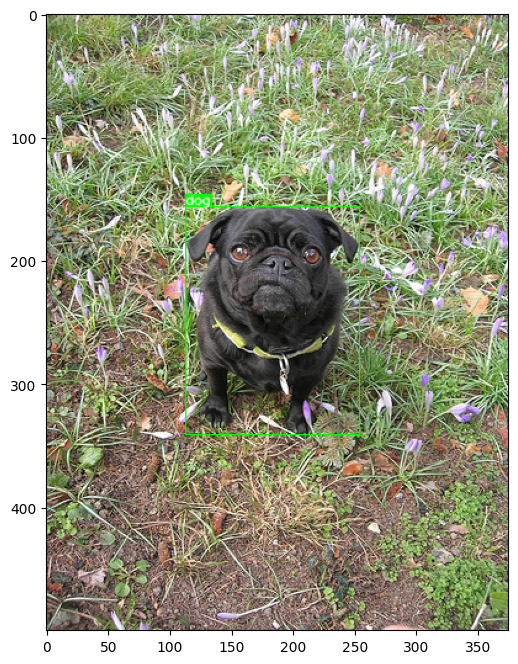

In [20]:
# Выберем рандомный индекс и выведем
# преобразованное изображение из датасета
random_image_idx = np.random.choice(range(len(train_data)))
plot_img(train_data, random_image_idx)

## Загрузка модели

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cuda


Загружаем предобученную модель.

In [22]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 158MB/s]  


In [23]:
num_classes = len(np.unique(xml_df['class']))
print(f'Число классов: {num_classes}')

# Получим число входных признаков для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

print(model.roi_heads)
# Заменим классификатор на новый
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads)

Число классов: 20
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=20, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=80, bias=True)
  )
)


In [24]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

Напишем функции для тренировки и валидации модели. Единственным отличием между ними будет отсутствие расчета градиента при валидации.Внутри функций мы переводим все данные внутри бача на устройство, на котором будут производится расчеты. Затем подаем полученные тензоры в модель и получаем словарь со значениями функций потерь. После этого посчитаем их сумму и для удобства запишем ее в переменную `running_loss` для отслеживания прогресса обучения. В конце каждой эпохи будем выводить среднее значение функций потерь.

In [25]:
def train(train_dataloader, rep_freq=10):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
        losses.backward()
        optimizer.step()
        if i % rep_freq == 0:
            print(f"\tИтерация #{i} losses: {losses}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(valid_dataloader):
    running_loss = 0
    for data in valid_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
    val_loss = running_loss/len(valid_dataloader.dataset)
    return val_loss

## Обучение

Начинаем обучение. Создадим два списка, куда будем сохранять значения функций потерь после каждой эпохи на тренировке и валидации

In [26]:
NUM_EPOCHS = 10
REP_FREQ = 100

train_losses = []
val_losses = []
try:
    for epoch in range(NUM_EPOCHS):
        start = time()
        train_loss = train(train_data_loader, rep_freq=REP_FREQ)
        val_loss = val(valid_data_loader)
        scheduler.step()
        print(f"Эпоха #{epoch + 1} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch + 1} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')

	Итерация #0 losses: 3.1867680097904496
	Итерация #100 losses: 0.35274693034794863
	Итерация #200 losses: 0.5674571583398387
	Итерация #300 losses: 0.37536877629747134
	Итерация #400 losses: 0.3477062764586539
	Итерация #500 losses: 0.205695922333211
	Итерация #600 losses: 0.9147868486296697
	Итерация #700 losses: 0.16988287981983274
Эпоха #1 train_loss: 0.11469664082602989, val_loss: 0.09703730147926616
Потрачено 9.5 минут на 1 эпоху
	Итерация #0 losses: 0.4644441937003435
	Итерация #100 losses: 0.3271212706965315
	Итерация #200 losses: 0.46455200842656225
	Итерация #300 losses: 0.34086140802560544
	Итерация #400 losses: 0.30402976358725575
	Итерация #500 losses: 0.17261110641606128
	Итерация #600 losses: 0.739405665764168
	Итерация #700 losses: 0.16723172900703015
Эпоха #2 train_loss: 0.09829244638484026, val_loss: 0.0952732432517046
Потрачено 9.5 минут на 2 эпоху
	Итерация #0 losses: 0.5485620823357232
	Итерация #100 losses: 0.3098380697079509
	Итерация #200 losses: 0.38860627500045

Визуализируем динамику лоссов

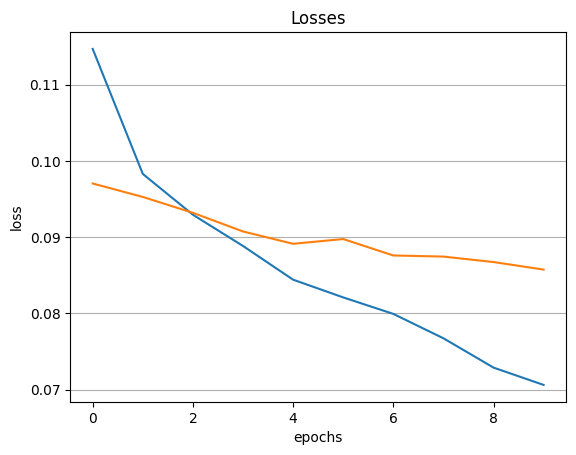

In [27]:
plt.title('Losses')
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(axis='y')
plt.show()

## Предсказание

Напишем функцию для получения предсказаний по интересующей нас выборке

In [28]:
def eval_fn(data_loader, model, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            output = model(images)
        
            for i in range(len(images)):
                boxes = output[i]['boxes'].detach().cpu().numpy()
                labels = output[i]['labels'].detach().cpu().numpy()
                scores = output[i]['scores'].detach().cpu().numpy()

                all_predictions.append({
                    'pred_boxes': (boxes).astype(int),
                    'labels': (labels).astype(int),
                    'scores': scores,
                    'true_boxes': (targets[i]['boxes'].cpu().numpy()).astype(int),
                    'true_labels': (targets[i]['labels'].cpu().numpy()).astype(int),
                    'image_id': image_ids[i]
                })

    return all_predictions

In [29]:
all_predictions = eval_fn(valid_data_loader, model, device)

100%|██████████| 176/176 [00:55<00:00,  3.19it/s]


Соберем из предсказаний таблицу. 

In [30]:
preds_rows = []
for entry in all_predictions:
    for i in range(len(entry['pred_boxes'])):
        preds_rows.append(
            [entry['pred_boxes'][i][0],
             entry['pred_boxes'][i][1],
             entry['pred_boxes'][i][2],
             entry['pred_boxes'][i][3],
             entry['labels'][i],
             labels_dict[entry['labels'][i]],
             entry['scores'][i],
             entry['image_id'] + '.jpg']
             )

preds_df = pd.DataFrame(
    preds_rows,
    columns=[
        'xmin', 'ymin', 'xmax', 'ymax',
        'class', 'name', 'scores', 'filename'
    ]
)


preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,1,125,133,364,14,person,0.989753,2010_003014.jpg
1,114,119,234,381,14,person,0.983126,2010_003014.jpg
2,243,178,491,380,14,person,0.979910,2010_003014.jpg
3,257,1,423,259,14,person,0.965163,2010_003014.jpg
4,231,30,450,366,14,person,0.831905,2010_003014.jpg


In [31]:
#Сохраняем полученные предсказания
preds_df.to_csv('preds_df.csv', index=False)

In [32]:
preds_df = pd.read_csv('preds_df.csv')

preds_df.head()

,xmin,ymin,xmax,ymax,class,name,scores,filename
0,1,125,133,364,14,person,0.989753,2010_003014.jpg
1,114,119,234,381,14,person,0.983126,2010_003014.jpg
2,243,178,491,380,14,person,0.979910,2010_003014.jpg
3,257,1,423,259,14,person,0.965163,2010_003014.jpg
4,231,30,450,366,14,person,0.831905,2010_003014.jpg


Посмотрим, насколько предсказания охватывают состав валидационной выборки.

In [38]:
set1 = set(list(preds_df.filename.values))
set2 = set(list(valid_df.filename.values))
intersection = set1.intersection(set2)
union_set = set1 | set2

print(len(intersection) / len(union_set))
print(preds_df.filename.nunique(), valid_df.filename.nunique())

0.9985734664764622
700 701


## Визуализация предсказаний

In [39]:
# Функция для рассчета площади пересечения двух прямоугольников
def calculate_iou(box1, box2):
    x_left = max(box1['xmin'], box2['xmin'])
    y_top = max(box1['ymin'], box2['ymin'])
    x_right = min(box1['xmax'], box2['xmax'])
    y_bottom = min(box1['ymax'], box2['ymax'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    box1_area = (box1['xmax'] - box1['xmin']) * (box1['ymax'] - box1['ymin'])
    box2_area = (box2['xmax'] - box2['xmin']) * (box2['ymax'] - box2['ymin'])
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    
    return iou


def draw_predict(filename, iou_threshold=0.5, score_threshold=0.15):
    for i in range(len(valid_data)):
        if valid_data[i][-1] == filename.split('.')[0]:
            img = image_convert(valid_data[i][0])
    
    preds = preds_df[preds_df['filename'].isin([filename])]
    true = valid_df[valid_df['filename'].isin([filename])]
        
    for j in range(len(preds)):
        for k in range(len(true)):
            pred_box = preds.iloc[j][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
            true_box = true.iloc[k][['xmin', 'ymin', 'xmax', 'ymax']].to_dict()
            iou = calculate_iou(pred_box, true_box)
            score = preds['scores'].values[j]
            if (iou > iou_threshold) and (score > score_threshold):
                label = preds['name'].values[j]
                cv2.rectangle(img,
                    (pred_box['xmin'], pred_box['ymin']),
                    (pred_box['xmax'], pred_box['ymax']),
                    (255, 0, 0), thickness=1
                )
                ((text_width, text_height), _) = cv2.getTextSize(
                    f"{label} {score:.2f}", cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1
                )
                cv2.rectangle(img,
                    (pred_box['xmin'], pred_box['ymin'] - 3 - int(1.3 * text_height)),
                    (pred_box['xmin'] + text_width, pred_box['ymin']), (255, 0, 0), -1
                )
                cv2.putText(img,
                    text=f"{label} {score:.2f}",
                    org=(pred_box['xmin'], pred_box['ymin'] - 3),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.35,
                    color=(255, 255, 255),
                    lineType=cv2.LINE_AA,
                )
                
    plt.figure(figsize=(10, 8))
    plt.imshow(img)

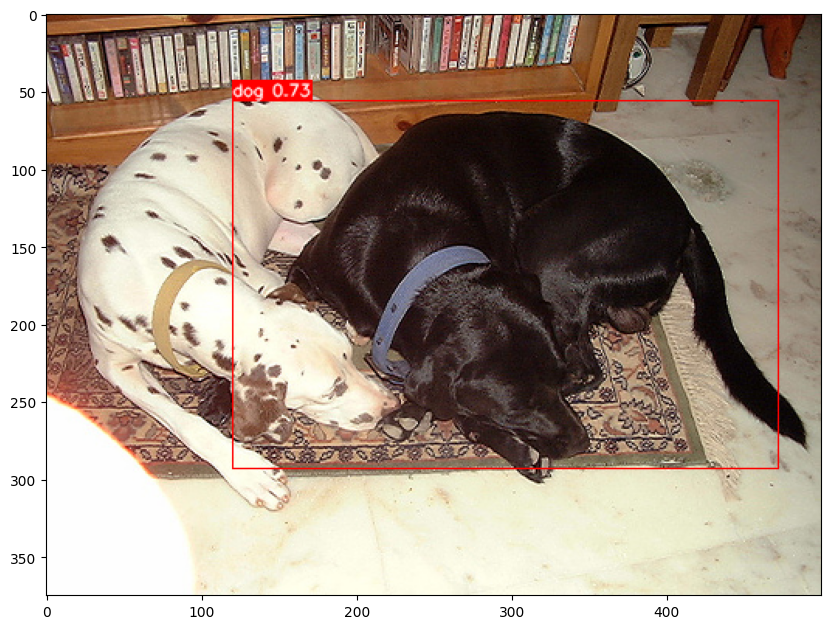

In [48]:
random_image_name = np.random.choice(list(preds_df.filename.unique()))
draw_predict(random_image_name, iou_threshold=0.5, score_threshold=0.5)

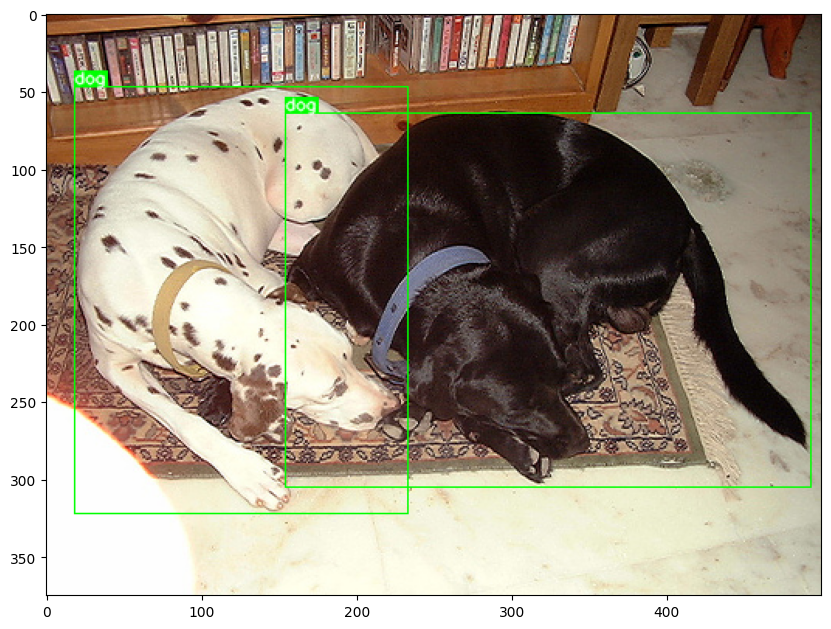

In [49]:
for i in range(len(valid_data)):
    if valid_data[i][-1] == random_image_name.split('.')[0]:
        plot_img(valid_data, i)

## Считаем accuracy

Напишем функцию, которая будет итерироваться по таблице с предсказаниями, выбирать из таблицы составленной из аннотаций строки по совпадающему `filename`, фильтровать по указанному порогу IoU детекции объектов, и если текущий IoU проходит порог, то алгоритм переходит к следующему этапу — к сравнению классов объекта в обоих таблицах: есть совпадение — счетчик += 1. Accuracy считаем как отношение счетчика к общему числу предсказаний.

In [50]:
def calculate_detection_accuracy(true_df=valid_df, preds=preds_df):
    correct_objects = 0
    
    for _, pred_row in preds.iterrows():
        filename = pred_row['filename']
        pred_box = {
            'xmin': pred_row['xmin'],
            'ymin': pred_row['ymin'],
            'xmax': pred_row['xmax'],
            'ymax': pred_row['ymax']
        }
        pred_class = pred_row['class']
        
        valid_boxes = true_df[true_df['filename'] == filename]
        
        for _, valid_row in valid_boxes.iterrows():
            valid_box = {
                'xmin': valid_row['xmin'],
                'ymin': valid_row['ymin'],
                'xmax': valid_row['xmax'],
                'ymax': valid_row['ymax']
            }
            valid_class = valid_row['class']
            
            iou = calculate_iou(pred_box, valid_box)
            if iou != 0:
                if pred_class == valid_class:
                    correct_objects += 1
                    
    accuracy = correct_objects / preds_df.shape[0]

    return accuracy

Посчитаем, наконец, accuracy.

In [51]:
print(f'Accuracy: {calculate_detection_accuracy(valid_df, preds_df):.3f}')

Accuracy: 0.502
